In [1]:
pip install requests pandas numpy plotly streamlit matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# Imports

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


# Pulling the Population Data from World Bank API

In [14]:
def fetch_world_bank(indicator, name):
    """Fetch data from World Bank API for all countries"""
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}"
    params = {
        'format': 'json',
        'per_page': 20000,
        'mrv': 10
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    records = []
    for item in data[1]:
        if item['value'] is not None:
            records.append({
                'country_code': item.get('countryiso3code', ''),  # 3-letter ISO code
                'country_name': item['country']['value'],
                'year': int(item['date']),
                name: item['value']
            })
    
    # Remove rows with empty country codes
    df = pd.DataFrame(records)
    df = df[df['country_code'] != '']
    return df

# Re-fetch all indicators
print("Fetching population data...")
df_pop = fetch_world_bank('SP.POP.TOTL', 'population')
print(f"✅ Population: {df_pop.shape} | Sample codes: {df_pop['country_code'].head(3).tolist()}")

print("Fetching net migration data...")
df_mig = fetch_world_bank('SM.POP.NETM', 'net_migration')
print(f"✅ Net Migration: {df_mig.shape} | Sample codes: {df_mig['country_code'].head(3).tolist()}")

print("Fetching GDP per capita data...")
df_gdp = fetch_world_bank('NY.GDP.PCAP.CD', 'gdp_per_capita')
print(f"✅ GDP per capita: {df_gdp.shape}")

print("Fetching life expectancy data...")
df_life = fetch_world_bank('SP.DYN.LE00.IN', 'life_expectancy')
print(f"✅ Life Expectancy: {df_life.shape}")

print("Fetching fertility rate data...")
df_fert = fetch_world_bank('SP.DYN.TFRT.IN', 'fertility_rate')
print(f"✅ Fertility Rate: {df_fert.shape}")

Fetching population data...
✅ Population: (2610, 4) | Sample codes: ['AFE', 'AFE', 'AFE']
Fetching net migration data...
✅ Net Migration: (2610, 4) | Sample codes: ['AFE', 'AFE', 'AFE']
Fetching GDP per capita data...
✅ GDP per capita: (2520, 4)
Fetching life expectancy data...
✅ Life Expectancy: (2610, 4)
Fetching fertility rate data...
✅ Fertility Rate: (2610, 4)


# Pulling the Country Metadata from REST Countries API

In [15]:
print("Fetching country metadata from World Bank...")
url = "https://api.worldbank.org/v2/country?format=json&per_page=300"
response = requests.get(url)
data = response.json()

records = []
for c in data[1]:
    if c['region']['id'] != 'NA':  # skip aggregates
        records.append({
            'country_code': c['id'],
            'region': c['region']['value'],
            'income_level': c['incomeLevel']['value'],
            'capital': c.get('capitalCity', 'Unknown'),
        })

df_meta = pd.DataFrame(records)
print(f"✅ Country Metadata: {df_meta.shape}")
print(f"Regions: {df_meta['region'].unique().tolist()}")
print(f"Income levels: {df_meta['income_level'].unique().tolist()}")
print(df_meta.head())

Fetching country metadata from World Bank...
✅ Country Metadata: (217, 4)
Regions: ['Latin America & Caribbean ', 'Middle East, North Africa, Afghanistan & Pakistan', 'Sub-Saharan Africa ', 'Europe & Central Asia', 'East Asia & Pacific', 'South Asia', 'North America']
Income levels: ['High income', 'Low income', 'Lower middle income', 'Upper middle income', 'Not classified']
  country_code                                             region  \
0          ABW                         Latin America & Caribbean    
1          AFG  Middle East, North Africa, Afghanistan & Pakistan   
2          AGO                                Sub-Saharan Africa    
3          ALB                              Europe & Central Asia   
4          AND                              Europe & Central Asia   

          income_level           capital  
0          High income        Oranjestad  
1           Low income             Kabul  
2  Lower middle income            Luanda  
3  Upper middle income            T

# Merging All Datasets

In [17]:
# Check sample codes from each dataset
print("=== Sample codes from population data ===")
print(df_pop['country_code'].head(10).tolist())

print("\n=== Sample codes from metadata ===")
print(df_meta['country_code'].head(10).tolist())

# Check overlap
pop_codes = set(df_pop['country_code'].unique())
meta_codes = set(df_meta['country_code'].unique())
overlap = pop_codes.intersection(meta_codes)
print(f"\nCodes in population data: {len(pop_codes)}")
print(f"Codes in metadata: {len(meta_codes)}")
print(f"Overlapping codes: {len(overlap)}")
print(f"Sample overlapping codes: {list(overlap)[:10]}")

=== Sample codes from population data ===
['AFE', 'AFE', 'AFE', 'AFE', 'AFE', 'AFE', 'AFE', 'AFE', 'AFE', 'AFE']

=== Sample codes from metadata ===
['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG']

Codes in population data: 261
Codes in metadata: 217
Overlapping codes: 217
Sample overlapping codes: ['UKR', 'LVA', 'COD', 'WSM', 'LKA', 'NRU', 'NGA', 'XKX', 'CYP', 'ASM']


In [16]:
# Merge all World Bank indicators on country + year
df = df_pop.merge(df_mig, on=['country_code', 'country_name', 'year'], how='left')
df = df.merge(df_gdp, on=['country_code', 'country_name', 'year'], how='left')
df = df.merge(df_life, on=['country_code', 'country_name', 'year'], how='left')
df = df.merge(df_fert, on=['country_code', 'country_name', 'year'], how='left')

# Merge country metadata
df = df.merge(df_meta, on='country_code', how='left')

# Remove aggregate regions — these have 3-digit numeric-style or special codes
# Keep only rows where region is not NaN (real countries have region data)
df = df.dropna(subset=['region'])

# Remove known aggregate entries by name keywords
agg_keywords = ['small states', 'income', 'OECD', 'euro area', 'world', 
                'blend', 'situations', 'members', 'IDA', 'IBRD', 'not classified']
mask = ~df['country_name'].str.lower().str.contains('|'.join(agg_keywords), na=False)
df = df[mask]

# Drop rows with no population or migration data
df = df.dropna(subset=['population', 'net_migration'])

# Reset index
df = df.reset_index(drop=True)

print(f"✅ Final merged dataset: {df.shape}")
print(f"Countries: {df['country_name'].nunique()}")
print(f"Years: {sorted(df['year'].unique())}")
print(f"Regions: {df['region'].unique().tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")
df.head()

✅ Final merged dataset: (1953, 11)
Countries: 217
Years: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Regions: ['Middle East, North Africa, Afghanistan & Pakistan', 'Europe & Central Asia', 'East Asia & Pacific', 'Sub-Saharan Africa ', 'Latin America & Caribbean ', 'South Asia', 'North America']
Missing values:
country_code         0
country_name         0
year                 0
population           0
net_migration        0
gdp_per_capita      85
life_expectancy    217
fertility_rate     217
region               0
income_level         0
capital              0
dtype: int64


,country_code,country_name,year,population,net_migration,gdp_per_capita,life_expectancy,fertility_rate,region,income_level,capital
0,AFG,Afghanistan,2024,42647492,-44089.0,NaN,NaN,NaN,"Middle East, North Africa, Afghanistan & Pakistan",Low income,Kabul
1,AFG,Afghanistan,2023,41454761,-48958.0,413.757895,66.035,4.840,"Middle East, North Africa, Afghanistan & Pakistan",Low income,Kabul
2,AFG,Afghanistan,2022,40578842,-647402.0,357.261153,65.617,4.932,"Middle East, North Africa, Afghanistan & Pakistan",Low income,Kabul
3,AFG,Afghanistan,2021,40000412,-548784.0,356.496214,60.417,5.039,"Middle East, North Africa, Afghanistan & Pakistan",Low income,Kabul
4,AFG,Afghanistan,2020,39068979,143634.0,510.787063,61.454,5.145,"Middle East, North Africa, Afghanistan & Pakistan",Low income,Kabul


# Feature Engineering

In [18]:
# Forward fill life expectancy and fertility (use last known value for 2024)
df = df.sort_values(['country_code', 'year'])
df[['life_expectancy', 'fertility_rate', 'gdp_per_capita']] = (
    df.groupby('country_code')[['life_expectancy', 'fertility_rate', 'gdp_per_capita']]
    .ffill()
)

# Migration rate per 1000 population
df['migration_rate'] = (df['net_migration'] / df['population']) * 1000

# Migration direction
df['migration_type'] = df['net_migration'].apply(
    lambda x: 'Net Immigration' if x > 0 else 'Net Emigration'
)

# Population growth YoY
df['pop_growth'] = df.groupby('country_code')['population'].pct_change() * 100

# GDP categories
df['gdp_category'] = pd.cut(
    df['gdp_per_capita'],
    bins=[0, 1000, 5000, 20000, float('inf')],
    labels=['Low Income', 'Lower Middle', 'Upper Middle', 'High Income']
)

# Clean region names
df['region'] = df['region'].str.strip()

print(f"✅ Features engineered")
print(f"\nMigration type distribution:")
print(df[df['year'] == 2023]['migration_type'].value_counts())
print(f"\nGDP category distribution:")
print(df[df['year'] == 2023]['gdp_category'].value_counts())
df.head()

✅ Features engineered

Migration type distribution:
Net Emigration     123
Net Immigration     94
Name: migration_type, dtype: int64

GDP category distribution:
High Income     73
Upper Middle    62
Lower Middle    59
Low Income      18
Name: gdp_category, dtype: int64


,country_code,country_name,year,population,net_migration,gdp_per_capita,life_expectancy,fertility_rate,region,income_level,capital,migration_rate,migration_type,pop_growth,gdp_category
89,ABW,Aruba,2016,108727,405.0,27441.550214,75.540,1.848,Latin America & Caribbean,High income,Oranjestad,3.724926,Net Immigration,NaN,High Income
88,ABW,Aruba,2017,108735,434.0,28440.041688,75.620,1.785,Latin America & Caribbean,High income,Oranjestad,3.991355,Net Immigration,0.007358,High Income
87,ABW,Aruba,2018,108908,431.0,30082.158423,75.880,1.732,Latin America & Caribbean,High income,Oranjestad,3.957469,Net Immigration,0.159102,High Income
86,ABW,Aruba,2019,109203,420.0,30645.890602,76.019,1.701,Latin America & Caribbean,High income,Oranjestad,3.846048,Net Immigration,0.270871,High Income
85,ABW,Aruba,2020,108587,0.0,22759.807175,75.406,1.662,Latin America & Caribbean,High income,Oranjestad,0.000000,Net Emigration,-0.564087,High Income


# Core Analysis

In [19]:
latest = df[df['year'] == 2023].copy()

# --- Analysis 1: Top 10 immigration destinations ---
top_immigration = (latest.nlargest(10, 'net_migration')
                   [['country_name', 'net_migration', 'migration_rate', 'gdp_per_capita', 'region']]
                   .reset_index(drop=True))
print("=== Top 10 Immigration Destinations (2023) ===")
print(top_immigration)

# --- Analysis 2: Top 10 emigration sources ---
top_emigration = (latest.nsmallest(10, 'net_migration')
                  [['country_name', 'net_migration', 'migration_rate', 'gdp_per_capita', 'region']]
                  .reset_index(drop=True))
print("\n=== Top 10 Emigration Sources (2023) ===")
print(top_emigration)

# --- Analysis 3: Migration by region ---
region_summary = (latest.groupby('region').agg(
    countries       = ('country_name', 'count'),
    total_migration = ('net_migration', 'sum'),
    avg_gdp         = ('gdp_per_capita', 'mean'),
    avg_life_exp    = ('life_expectancy', 'mean')
).round(1).sort_values('total_migration', ascending=False))
print("\n=== Migration Summary by Region (2023) ===")
print(region_summary)

# --- Analysis 4: GDP vs Migration correlation ---
corr = latest[['gdp_per_capita', 'net_migration', 'migration_rate', 
               'life_expectancy', 'fertility_rate']].corr()
print("\n=== Correlation Matrix ===")
print(corr.round(2))

=== Top 10 Immigration Destinations (2023) ===
           country_name  net_migration  migration_rate  gdp_per_capita  \
0         United States      1322668.0        3.927089    81032.262118   
1  Syrian Arab Republic       757309.0       32.096677     1051.671496   
2               Germany       609553.0        7.318681    54776.766824   
3                  Chad       496830.0       25.717084      949.333454   
4           South Sudan       455000.0       39.622501             NaN   
5        United Kingdom       445523.0        6.504745    49944.470212   
6                Canada       433842.0       10.823460    54220.328504   
7          Saudi Arabia       325691.0        9.663638    36156.848338   
8      Egypt, Arab Rep.       305006.0        2.662976     3456.789685   
9  United Arab Emirates       300004.0       28.616094    49850.687218   

                                              region  
0                                      North America  
1  Middle East, North Africa

# Visualizations

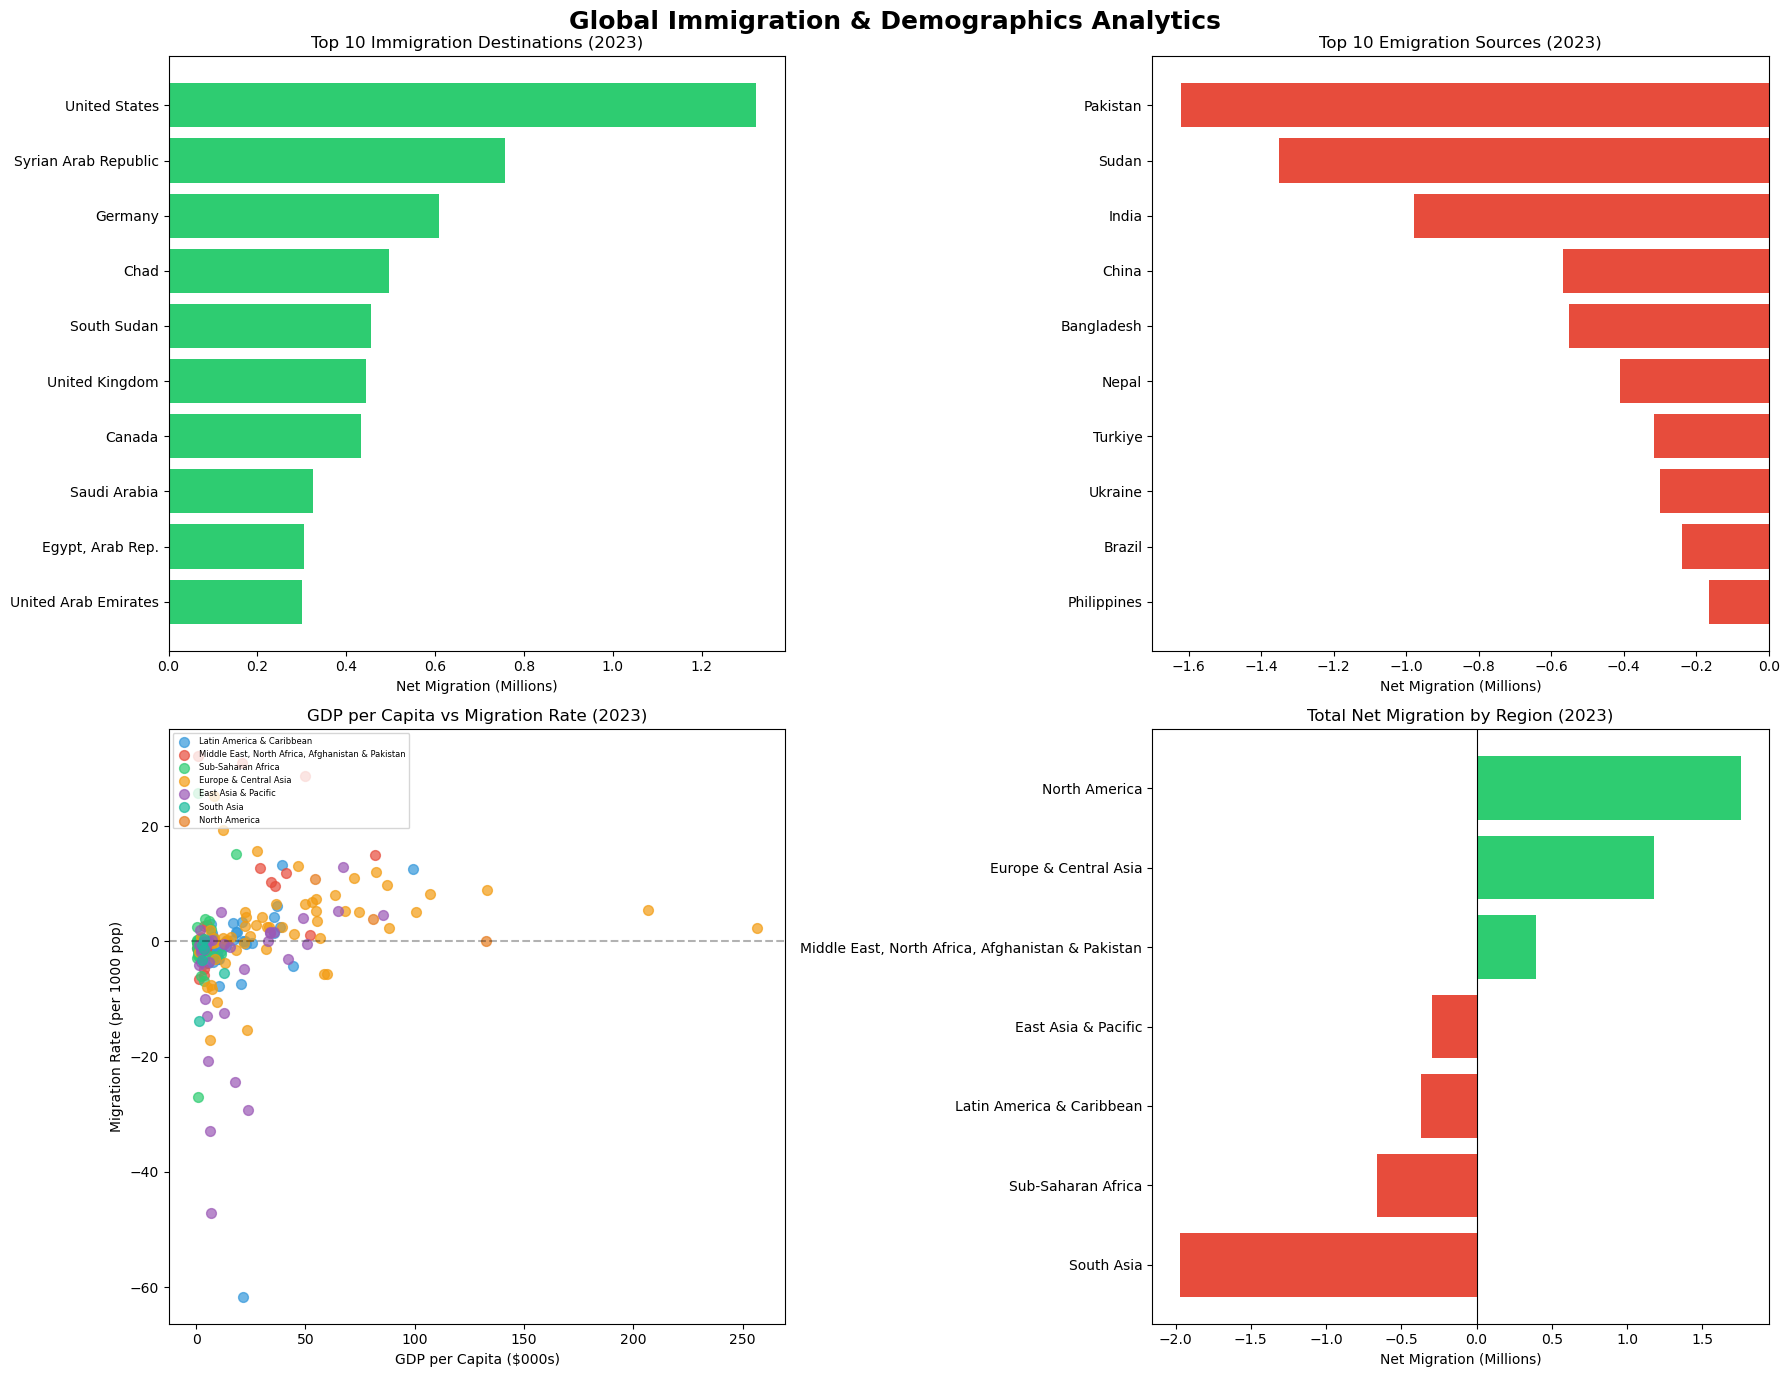

✅ Visualization saved!


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Global Immigration & Demographics Analytics', fontsize=18, fontweight='bold')

# 1 — Top 10 immigration destinations
ax1 = axes[0, 0]
data = latest.nlargest(10, 'net_migration').sort_values('net_migration')
ax1.barh(data['country_name'], data['net_migration'] / 1e6, color='#2ecc71')
ax1.set_title('Top 10 Immigration Destinations (2023)')
ax1.set_xlabel('Net Migration (Millions)')

# 2 — Top 10 emigration sources
ax2 = axes[0, 1]
data2 = latest.nsmallest(10, 'net_migration').sort_values('net_migration', ascending=False)
ax2.barh(data2['country_name'], data2['net_migration'] / 1e6, color='#e74c3c')
ax2.set_title('Top 10 Emigration Sources (2023)')
ax2.set_xlabel('Net Migration (Millions)')

# 3 — GDP vs Migration Rate scatter
ax3 = axes[1, 0]
regions = latest['region'].unique()
colors = ['#3498db','#e74c3c','#2ecc71','#f39c12','#9b59b6','#1abc9c','#e67e22']
for i, region in enumerate(regions):
    subset = latest[latest['region'] == region]
    ax3.scatter(subset['gdp_per_capita'] / 1000, subset['migration_rate'],
                label=region, alpha=0.7, s=50, color=colors[i % len(colors)])
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax3.set_title('GDP per Capita vs Migration Rate (2023)')
ax3.set_xlabel('GDP per Capita ($000s)')
ax3.set_ylabel('Migration Rate (per 1000 pop)')
ax3.legend(fontsize=6, loc='upper left')

# 4 — Migration by region bar chart
ax4 = axes[1, 1]
reg_data = latest.groupby('region')['net_migration'].sum().sort_values() / 1e6
colors4 = ['#e74c3c' if v < 0 else '#2ecc71' for v in reg_data.values]
ax4.barh(reg_data.index, reg_data.values, color=colors4)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax4.set_title('Total Net Migration by Region (2023)')
ax4.set_xlabel('Net Migration (Millions)')

plt.tight_layout()
save_path = r'C:\Users\Yash\Downloads\YASH\global_immigration_analytics\immigration_viz.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualization saved!")

# Export for Power BI

In [21]:
export_path = r'C:\Users\Yash\Downloads\YASH\global_immigration_analytics\immigration_clean.csv'
df.to_csv(export_path, index=False)
print(f"✅ Exported: immigration_clean.csv")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

✅ Exported: immigration_clean.csv
Shape: (1953, 15)
Columns: ['country_code', 'country_name', 'year', 'population', 'net_migration', 'gdp_per_capita', 'life_expectancy', 'fertility_rate', 'region', 'income_level', 'capital', 'migration_rate', 'migration_type', 'pop_growth', 'gdp_category']
